# CarND Project 3: Behavioral Cloning

In [1]:
import os
import argparse

import numpy as np
import pandas as pd
import cv2
import random
import math

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.backend import tf as ktf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

%matplotlib inline

FIGSIZE = (16, 6)
INPUT_FOLDER = 'mydata'
CROP_TOP, CROP_BOTTOM = 70, 24
MODEL_FILENAME = 'model.h5'

Using TensorFlow backend.


In [2]:
def read_csv(filename):
    columns = ('center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed')
    df = pd.read_csv(filename, skipinitialspace=True)
    df.columns = columns
    return df

def smoothen_steering(df, count=5):
    return df.ewm(span=count).mean()['steering']

def fix_image_paths(df, folder):
    fixpath = lambda s: os.path.join(folder, s.split('/')[-1])
    df['center'] = df['center'].map(fixpath)
    df['left'] = df['left'].map(fixpath)
    df['right'] = df['right'].map(fixpath)
    return df

def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def detect_input_shape(df):
    sample_image = df['center'].iloc[1]
    return load_image(sample_image).shape

def read_all_csvs_in_folder(parent_folder, min_speed=0.1):
    folders = os.listdir(parent_folder)
    folders = [os.path.join(parent_folder, folder) for folder in folders]
    
    data = []
    for folder in folders:
        df = read_csv(os.path.join(folder, 'driving_log.csv'))
        df = fix_image_paths(df, os.path.join(folder, 'IMG'))
        df['smooth_steering'] = smoothen_steering(df, count=10)
        data.append(df)
    
    columns = data[0].columns
    data = pd.DataFrame(data=np.concatenate(data), columns=columns)
    return data[data['speed'] >= min_speed]

data = read_all_csvs_in_folder(INPUT_FOLDER)
input_shape = detect_input_shape(data)

## A glimpse at the data

In [3]:
print('{} center image frames in total'.format(len(data)))
print('Input images have shape: {}'.format(input_shape))

12043 center image frames in total
Input images have shape: (160, 320, 3)


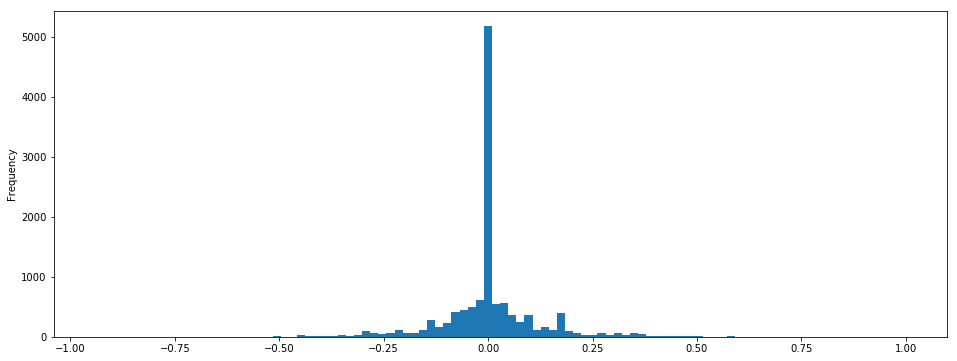

In [4]:
data['steering'].plot.hist(bins=100, figsize=FIGSIZE)

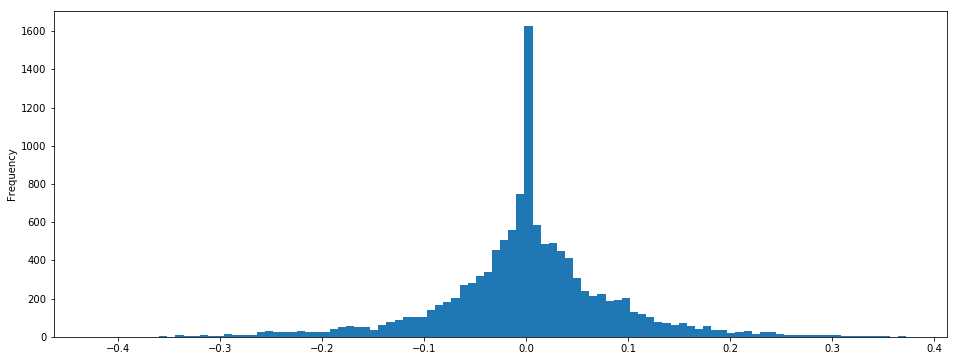

In [5]:
data['smooth_steering'].plot.hist(bins=100, figsize=FIGSIZE)

In [6]:
print('Steering left: {}'.format(len(data[data['steering'] < 0])))
print('Steering right: {}'.format(len(data[data['steering'] > 0])))
print('Steering straight: {}'.format(len(data[data['steering'] == 0])))

Steering left: 3883
Steering right: 3740
Steering straight: 4420


### Observation

As can be seen, the distribution of steering angles is off. There's disproportionately more data for straight driving (`steering~=0`). Furthermore, it seems that there's slightly more data for steering to the right.

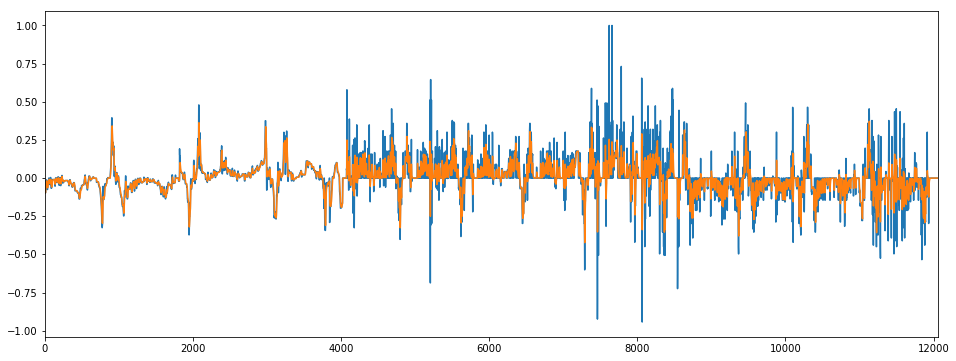

In [7]:
data['steering'].plot.line(figsize=FIGSIZE)
data['smooth_steering'].plot.line(figsize=FIGSIZE)

In [8]:
def crop(img):
    return img[CROP_TOP:img.shape[0]-CROP_BOTTOM, :, :]

def display(images, cols=2):
    shape = images[0].shape
    n_cols = cols if len(images) > cols else len(images)
    width = FIGSIZE[0]
    fig1 = plt.figure(1, (width, width * math.ceil(len(images)/n_cols)))
    grid1 = ImageGrid(fig1, 111,
                     nrows_ncols=(math.ceil(len(images)/n_cols), n_cols),
                     axes_pad=0.1,
                    )

    for index, img in enumerate(images):
        if len(shape) == 2:
            grid1[index].imshow(img, cmap='gray')
        else:
            grid1[index].imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))

[11633  6990  5984  2762]


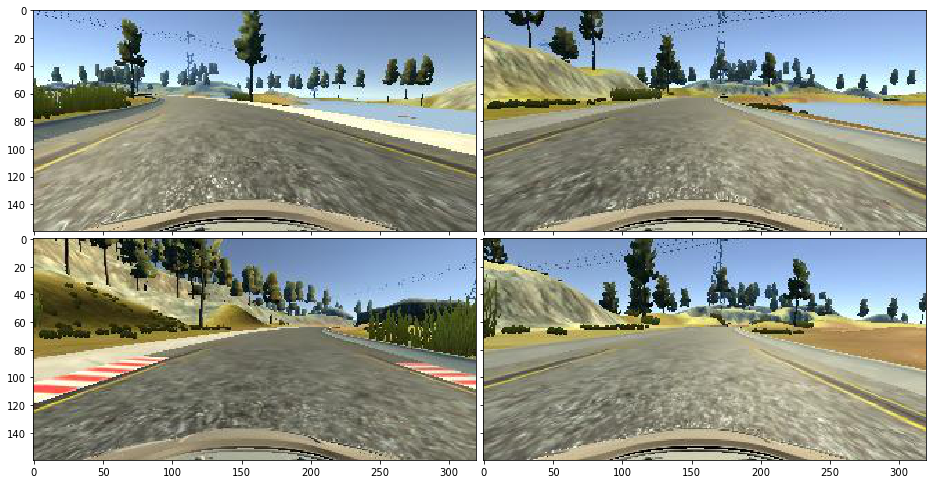

In [9]:
samples = np.random.choice(data.index, 4, replace=False)
print(samples)
sample_images = [load_image(data.iloc[sample]['center']) for sample in samples]
display(sample_images, cols=2)

Cropped image dimensions: (66, 320, 3)


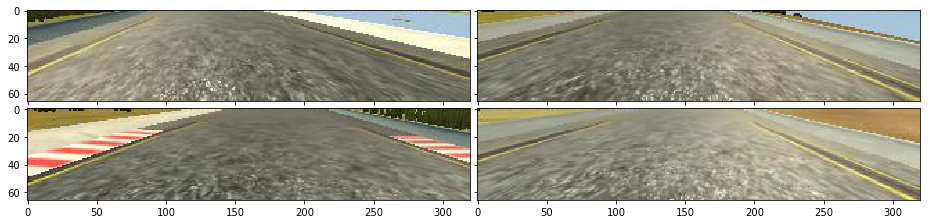

In [10]:
sample_images_cropped = [crop(load_image(data.iloc[sample]['center'])) for sample in samples]
print('Cropped image dimensions: {}'.format(sample_images_cropped[0].shape))
display(sample_images_cropped, cols=2)

#### Use Canny Edge Detection?

In [11]:
def preprocess_with_canny(img):
    grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(grayscale, (3, 3), 0)
    low_threshold = 50
    high_threshold = 150
    return cv2.Canny(blurred, low_threshold, high_threshold)

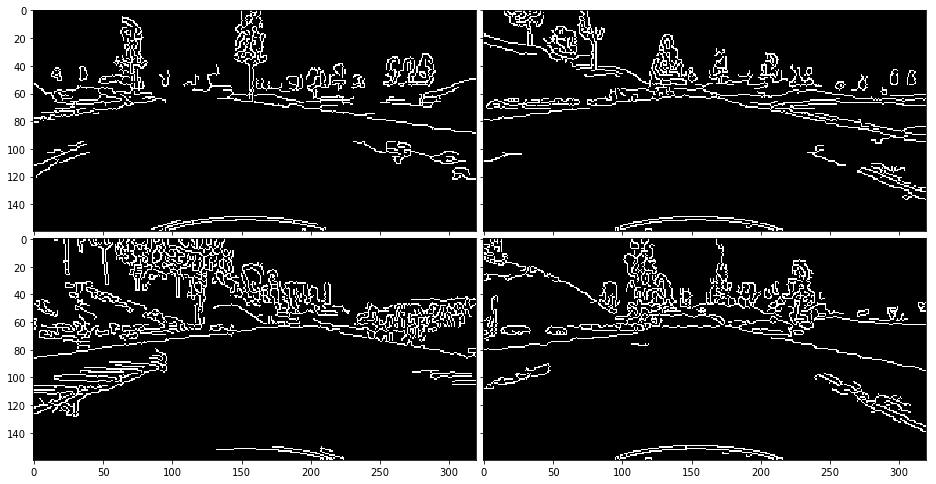

In [12]:
canny_images = list(map(preprocess_with_canny, sample_images))
display(canny_images, cols=2)

In [13]:
THRESHOLD = 0.05
random.seed()

In [14]:
def adjust_brightness(img_steering, amount):
    img, steering = img_steering
    result = img.copy().astype(np.int16)
    result[:,:,2] += amount
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result, steering

def add_noise(img_steering, maximum=10):
    img, steering = img_steering
    noise = np.random.randint(0, high=maximum, size=img.shape)
    result = img.copy().astype(np.int16)
    result = np.clip(np.rint(result + noise), 0, 255).astype(np.uint8)
    return result, steering

def flip(img, steering):
    return np.fliplr(img.copy()), -steering

def get_side_image(left: bool, image, center_steering, steering_correction=0.25):
    steering = (center_steering + steering_correction) if left else (center_steering - steering_correction)
    return image, steering

In [15]:
sample_images_bright = [adjust_brightness((img, 0), 50)[0] for img in sample_images]
sample_images_dark = [adjust_brightness((img, 0), -50)[0] for img in sample_images]
sample_images_noise = [add_noise((img, 0))[0] for img in sample_images]
sample_images_flip = [flip(img, 0)[0] for img in sample_images]

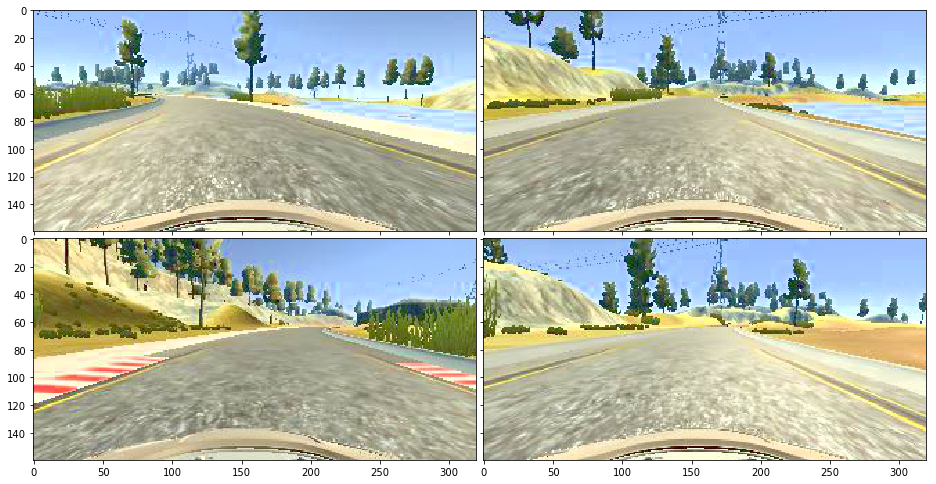

In [16]:
display(sample_images_bright, cols=2)

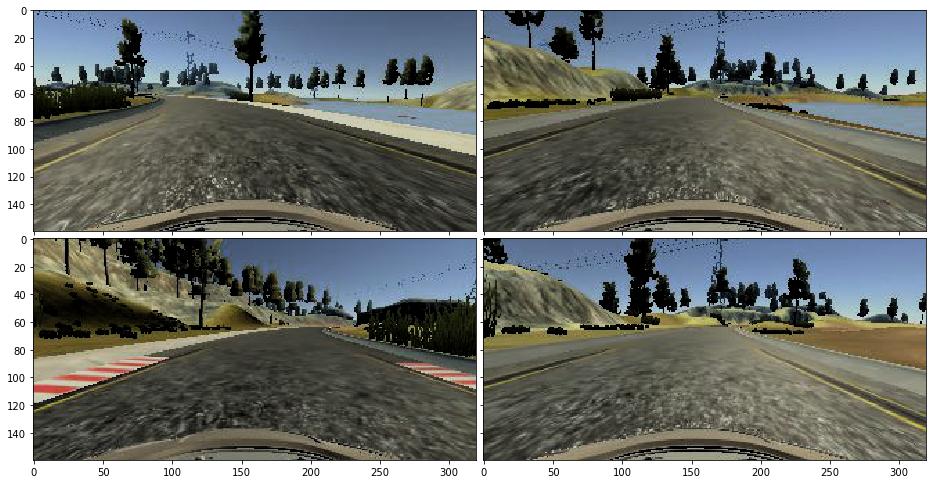

In [17]:
display(sample_images_dark, cols=2)

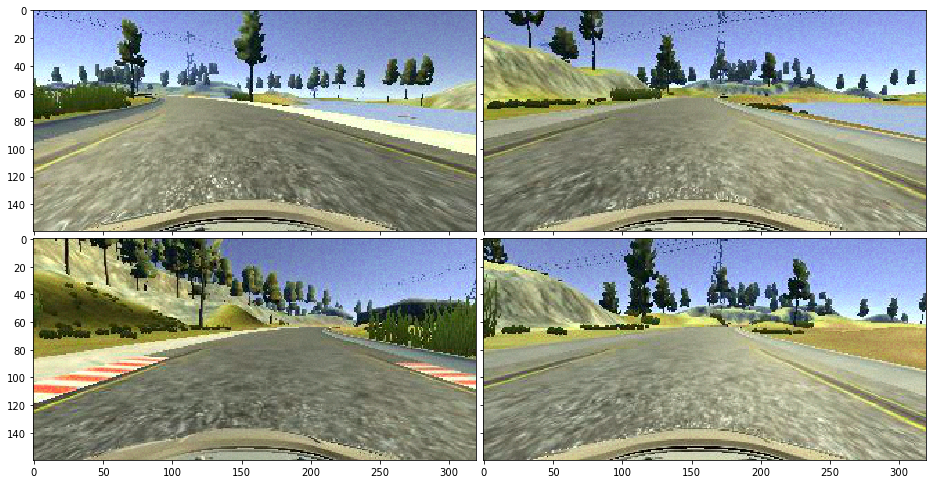

In [18]:
display(sample_images_noise)

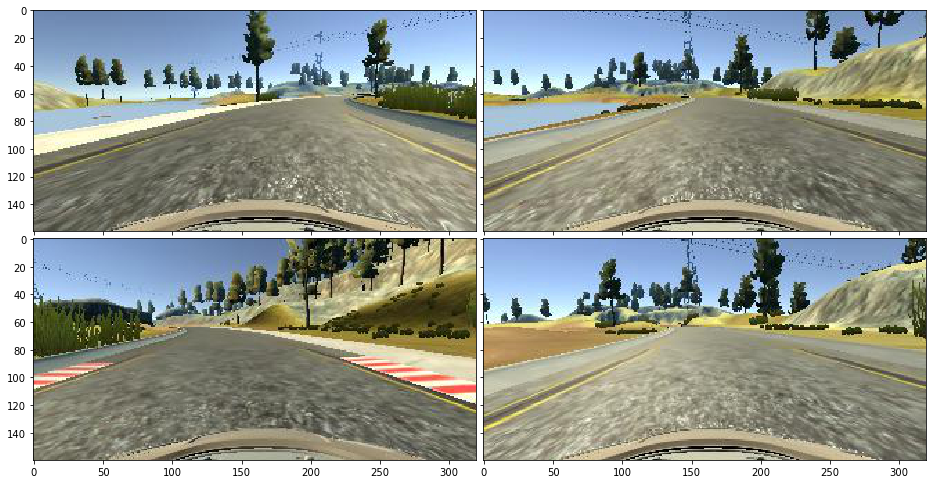

In [19]:
display(sample_images_flip)